---
title: "Naive Bayes"
format:
  html:
      embed-resources: true
      code-fold: true
---

## Introduction to Naive Bayes

Naive Bayes classification is a group of supervised learning algorithms which use Bayes' theorem as their foundation. The "naive" aspect of these algorithms is the assumption that every pair of features are conditionally independent. [^1] This can be better understood via the Bayes' Theorem formula and how it applies in Naive Bayes. Given an output variable $y$ and several feature variables $x_i$, Bayes' Theorem posits the following:

$P\left(y | x_1, \ldots, x_n\right)=\frac{P(y) P\left(x_1, \ldots, x_n | y\right)}{P\left(x_1, \ldots, x_n\right)}$

The assumption that all feature variables are conditionally independent can be represented with the formula

$P\left(x_i \mid y, x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n\right)=P\left(x_i \mid y\right)$

which essentially states that the values of each $x_i$ depend solely on $y$, not the values from any other feature variable. Thus, we can substitute the products of all conditional probabilities into Bayes' Theorem to represent the relationship as

$P\left(y \mid x_1, \ldots, x_n\right)=\frac{P(y) \prod_{i=1}^n P\left(x_i \mid y\right)}{P\left(x_1, \ldots, x_n\right)}$.

Using this foundation, Naive Bayes classification algorithms attempt to establish classifiers for a dataset by considering values for each feature and assigning probabilities that it belongs in a certain class of the specified output variable. To do this, the algorithm will first take in data from a test dataset. When executing Naive Bayes classification, it is generally recommended to partition cleaned data such that 80% of it belongs in the test dataset. The algorithm will iterate over the feature variables and observe the output, ultimately creating a model for the extents to which the feature variables predict the output classifications.

Due to the foundation being on Bayes' Theorem, these methods are probabilistic in nature. That is, rather than being able to decisively classify new data, the algorithms work based on conditional probabilities that records belong to a particular class.

Discerning when to use the different variants of Naive Bayes classification is crucial for obtaining meaningful results. Firstly, Gaussian Naive Bayes (GNB) assumes that the feature variables follow a normal distribution. Thus, if we have data that we know comes from a normally distributed population, we can use the appropriate likelihood function for parameter estimation. The same applies for other methods of Naive Bayes classification. Other popular algorithms include Multinomial Naive Bayes, Bernoulli Naive Bayes, Categorical Naive Bayes, and others. Essentially, the presumed distribution of the feature variables can be leveraged to give an appropriate likelihood function, which aids in estimating parameters.

### Naive Bayes for this Project

For the purposes of our analysis, Naive Bayes can be used to analyze both record and text data. Firstly, the record data we will be using is the Census data which contains survey responses on various demographic features. The purpose of this will be to apply the Categorical Naive Bayes algorithm to features such as sex, race, and marital status to fit a model with a respondant's method of transportation to commute to work as the output variable. This will allow us to gain insights on which types of people are most affected by changes in public transit policy and service, providing valuable context for how a city's conditions can impact its residents.

Secondly, the labeled text data that we will use is the combined dataset of Yelp reviews for WMATA and BART. These revies contain textual responses with accompanying numerical ratings (1-5 stars). Thus, the text will be considered the feature set for Multinomial Naive Bayes, with the ratings deemed the output, as it labels the review with a scale of satisfaction or dissatisfaction with a service. The purpose of this is to analyze public sentiment regarding public transit systems and how that may affect usage or responses to potential policy changes.

## Preparing Data for Naive Bayes

### Preparing Record Data

To prepare this data, the first step is to filter out columns that will not be fit in the Categorical Naive Bayes algorithm.

In [89]:
from codecs import ignore_errors
import comm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import shutil

commute=pd.read_csv("../data/cleaned_data/commute_by_demographic.csv")
commute = commute.drop(columns=['Unnamed: 0','year','id','age','personal_income','metropolitan_status'])

The goal of Naive Bayes is to predictions on your test data using a model that was built using test data. Thus, separating our present data into training and testing datasets is crucial for proper execution. It is generally best practice to partition 80% of this into the test dataset, which is done by specifying `test_size` in the `train_test_split` function of `sklearn`.

Given our present data, in order to execute Categorical Naive Bayes, we must encode the categorical data with associated numbers. `sklearn`, a machine learning software tool in Python which will be used throughout this process, has functions `OrdinalEncoder` and `LabelEncoder` to accomplish this. Thus, that will be applied to both train and test datasets once partitioned.

*Note: Code for feature selection with categorical variables partially repurposed from: https://machinelearningmastery.com/feature-selection-with-categorical-data/*

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

dataset = commute.values
X = dataset[:, :-1]
y = dataset[:,-1]
X = X.astype(str)

def prepare_inputs(X_train, X_test):
     oe = OrdinalEncoder()
     oe.fit(X_train)
     X_train_enc = oe.transform(X_train)
     X_test_enc = oe.transform(X_test)
     return X_train_enc, X_test_enc

def prepare_targets(y_train, y_test):
     le = LabelEncoder()
     le.fit(y_train)
     y_train_enc = le.transform(y_train)
     y_test_enc = le.transform(y_test)
     return y_train_enc, y_test_enc
 
def select_features(X_train, y_train, X_test):
     fs = SelectKBest(score_func=chi2, k='all')
     fs.fit(X_train, y_train)
     X_train_fs = fs.transform(X_train)
     X_test_fs = fs.transform(X_test)
     return X_train_fs, X_test_fs, fs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

### Preparing Text Data

To prepare this data, we must first combine WMATA and BART datasets of Yelp reviews. Since this is not an exercise in comparing and contrasting the two, it is necessary to leverage the scalability of Naive Bayes classification by consolidating this data. The next steps are to vectorize the text, randomly shuffle the records, and again split into training and test data sets, where 80% of the data belongs to the training set.

*Note: The code for this section is partially repurposed from DSAN-5000 Lab 3.2*

In [23]:
wmata_yelp=pd.read_csv("../data/cleaned_data/wmata_reviews_cleaned.csv")
bart_yelp=pd.read_csv("../data/cleaned_data/bart_reviews_cleaned.csv")
total_yelp = pd.concat([wmata_yelp,bart_yelp])
print(total_yelp.shape)
print(total_yelp.columns)

(1120, 3)
Index(['Rating', 'Date', 'Review'], dtype='object')


In [24]:
reviews=[]
ratings=total_yelp['Rating']
for i in range(0,wmata_yelp.shape[0]):
    keep="abcdefghijklmnopqrstuvwxyz "
    replace=".,!;"
    tmp=""
    for char in wmata_yelp['Review'][i].replace("<br />","").lower():
        if char in replace:
            tmp+=" "
        if char in keep:
            tmp+=char
    tmp=" ".join(tmp.split())
    reviews.append(tmp)

ratings = np.array(ratings)


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(corpus,MAX_FEATURES):
    vectorizer=CountVectorizer(max_features=MAX_FEATURES,stop_words="english")   

    Xs  =  vectorizer.fit_transform(corpus)   
    X=np.array(Xs.todense())

    maxs=np.max(X,axis=0)
    return (np.ceil(X/maxs),vectorizer.vocabulary_)

(x,vocab0)=vectorize(reviews,MAX_FEATURES=10000)
vocab1 = dict([(value, key) for key, value in vocab0.items()])
df2=pd.DataFrame(x)
s = df2.sum(axis=0)
df2=df2[s.sort_values(ascending=False).index[:]]
#print(df2.head())
i1=0
vocab2={}
for i2 in list(df2.columns):
    vocab2[i1]=vocab1[int(i2)]
    i1+=1
df2.columns = range(df2.columns.size)
x=df2.to_numpy()



In [26]:
import random
N=x.shape[0]
l = [*range(N)]
cut = int(0.8 * N)
random.shuffle(l)
train_index = l[:cut]
test_index = l[cut:]

print(train_index[0:10])
print(test_index[0:10])

[82, 103, 95, 99, 63, 15, 93, 53, 43, 33]
[69, 106, 6, 81, 105, 27, 9, 40, 13, 55]


## Feature Selection

### Feature Selection for Record Data

The following code and output provides the feature selection process for our record data.

sex: 920.6032333593723
marital_status: 1787.933741159745
race: 9440.200749960755
hispanic: 306.10785407861846
employment: nan


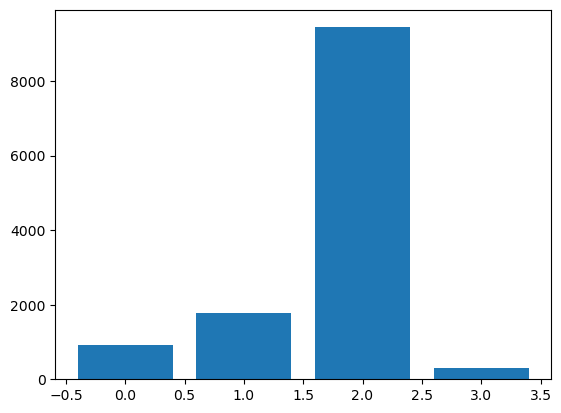

In [115]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
for i in range(len(fs.scores_)):
     print(str(commute.columns[i]) + ": " + str(fs.scores_[i]))
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

### Feature Selection for Text Data

The following code and output provides the feature selection process for our text data.

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(ratings))
print(x.shape,ratings.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,ratings,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(110, 2321) (1120,)
(110, 2321) (1120,)
98.86363636363636 54.54545454545454 0.04070899999999966 0.01037700000000008


In [29]:
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]

initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,ratings,i_print=False)

        if(i%5==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
partial_grid_search(num_runs=20, min_index=1000, max_index=10000)

5 50 50 81.81818181818183 81.81818181818183
10 100 100 85.22727272727273 77.27272727272727
15 150 150 89.77272727272727 68.18181818181817
20 200 200 90.9090909090909 68.18181818181817
25 250 250 93.18181818181817 63.63636363636363
30 300 300 95.45454545454545 59.09090909090909
35 350 350 96.5909090909091 50.0
40 400 400 96.5909090909091 50.0
45 450 450 96.5909090909091 40.909090909090914
50 500 500 95.45454545454545 45.45454545454545
55 550 550 95.45454545454545 50.0
60 600 600 97.72727272727273 50.0
65 650 650 97.72727272727273 54.54545454545454
70 700 700 97.72727272727273 50.0
75 750 750 97.72727272727273 59.09090909090909
80 800 800 97.72727272727273 50.0
85 850 850 97.72727272727273 50.0
90 900 900 97.72727272727273 45.45454545454545
95 950 950 97.72727272727273 45.45454545454545
100 1000 1000 97.72727272727273 54.54545454545454
5 3250 2321 98.86363636363636 54.54545454545454
10 5500 2321 98.86363636363636 54.54545454545454
15 7750 2321 98.86363636363636 54.54545454545454
20 10000

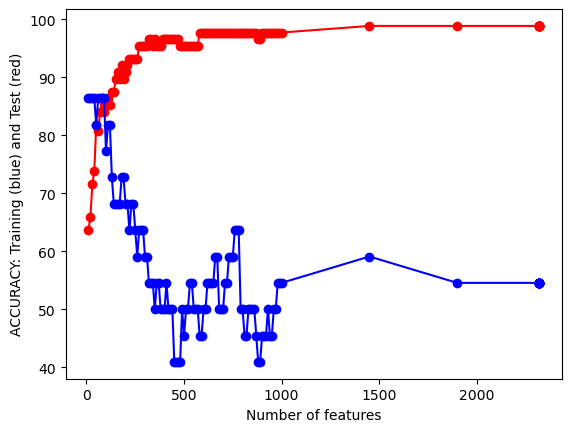

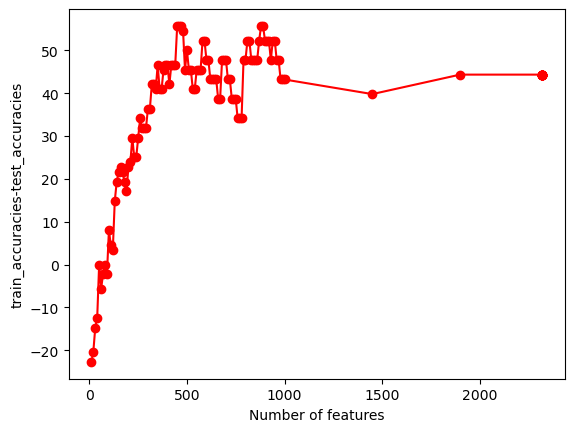

In [32]:
def save_results(path_root):
    out=np.transpose(np.array([num_features,train_accuracies,test_accuracies,train_time,eval_time])) 
    out=pd.DataFrame(out)
    out.to_csv(path_root+".csv")

def plot_results(path_root):
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (blue) and Test (red)')
    plt.savefig(path_root+'-1.png')
    plt.show()

    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'-4.png')
    plt.show()

save_results('../data/naive_bayes'+"/partial_grid_search")
plot_results('../data/naive_bayes'+"/partial_grid_search")

In [39]:
x_var=np.var(x,axis=0)
from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,ratings,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)

THRESHOLD = 0.017306925049871733 828
THRESHOLD = 0.025605585636933575 480
THRESHOLD = 0.03390424622399542 322
THRESHOLD = 0.04220290681105726 225
THRESHOLD = 0.050501567398119104 169
THRESHOLD = 0.05880022798518093 128
THRESHOLD = 0.06709888857224278 96
THRESHOLD = 0.07539754915930462 67
THRESHOLD = 0.08369620974636646 58
THRESHOLD = 0.0919948703334283 47
THRESHOLD = 0.10029353092049015 40
THRESHOLD = 0.10859219150755198 37
THRESHOLD = 0.11689085209461382 33
THRESHOLD = 0.12518951268167566 26
THRESHOLD = 0.13348817326873752 23
THRESHOLD = 0.14178683385579935 20
THRESHOLD = 0.15008549444286118 19
THRESHOLD = 0.15838415502992303 19
THRESHOLD = 0.16668281561698486 16
THRESHOLD = 0.17498147620404672 14
THRESHOLD = 0.18328013679110855 9
THRESHOLD = 0.1915787973781704 7
THRESHOLD = 0.19987745796523224 5
THRESHOLD = 0.20817611855229406 4
THRESHOLD = 0.21647477913935592 4
THRESHOLD = 0.22477343972641775 2
THRESHOLD = 0.2330721003134796 1


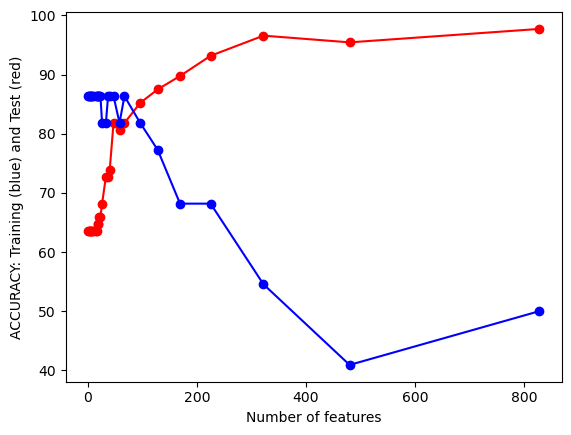

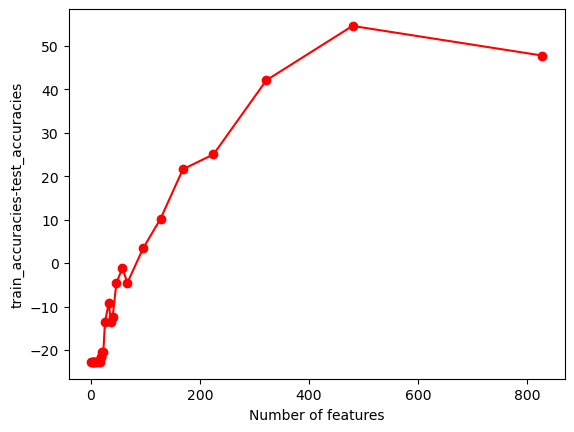

In [40]:
save_results("../data/naive_bayes"+"/variance_threshold")
plot_results("../data/naive_bayes"+"/variance_threshold")

## Naive Bayes

### Naive Bayes with Labeled Record Data

The following code, output, and comments show the process for Naive Bayes classification on record data.

In [135]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
import scipy
from scipy import stats
clf = CategoricalNB(force_alpha=True)
enc = OrdinalEncoder()

feature_cols = feature_cols = [c for c in commute.columns if c != 'transportation_type']
X_train_df = pd.DataFrame(X_train_enc, columns=feature_cols)
X_test_df = pd.DataFrame(X_test_enc, columns=feature_cols)
included_vars = ['sex','race','marital_status']
included_vars_df = X_train_df[included_vars].copy()
sex_marital_corr = stats.spearmanr(included_vars_df['sex'], included_vars_df['marital_status']).statistic
print(sex_marital_corr)
sex_race_corr = stats.spearmanr(included_vars_df['sex'], included_vars_df['race']).statistic
print(sex_race_corr)
race_marital_corr = stats.spearmanr(included_vars_df['race'], included_vars_df['marital_status']).statistic
print(race_marital_corr)
sex_commute_corr = stats.spearmanr(included_vars_df['sex'], y_train).statistic
print(sex_commute_corr)
race_commute_corr = stats.spearmanr(included_vars_df['race'], y_train).statistic
print(race_commute_corr)
marital_commute_corr = stats.spearmanr(included_vars_df['marital_status'], y_train).statistic
print(marital_commute_corr)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.004576510748920096
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.02050209664803721
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
-0.09405440809270636
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int

In [134]:
k = 3
mean_xx_corr = np.mean([sex_marital_corr,sex_race_corr,race_marital_corr])
mean_xy_corr = np.mean([sex_commute_corr,race_commute_corr,marital_commute_corr])
print(f"Number of features: {k}")
merit_score_numer = k * np.absolute(mean_xy_corr)
merit_score_denom = np.sqrt(k + k * (k + 1) * np.absolute(mean_xx_corr))
merit_score_s2 = merit_score_numer / merit_score_denom
print(f"Merit score: {merit_score_s2}")

Number of features: 3
Merit score: 0.02851309377702586


In [ ]:
enc.fit(X_train)
X_train_enc = enc.transform(X_train)
clf.fit(X_train_enc, y_train)

In [117]:
from sklearn.metrics import f1_score
enc.fit(X_test)
X_test_enc = enc.transform(X_test)
test_predictions = clf.predict(X_test_enc)
f1_score(y_true = y_test, y_pred = test_predictions, average='weighted')

0.6442288060648733

The following F1 score combines the precision and recall of a classifier. Given this score, it appears that our model was somewhat effective at predicting commute methods in terms of these metrics.

### Naive Bayes with Labeled Text Data

The following code, output, and comments show the process for Naive Bayes classification on record data.

In [140]:
wmata_yelp.head()

,Rating,Date,Review
0,5,"Jul 26, 2023",I had to compliment WMATA on the shuttle servi...
1,1,"Oct 27, 2023",Since when did metro close the doors to their ...
2,1,"Sep 29, 2023",So many things wrong with wmata I can't even b...
3,5,"Sep 23, 2023","I WFH, and WMATA has been very helpful in my m..."
4,4,"Sep 18, 2022",I took the metro while visiting DC. I began at...


In [144]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# CONVERT DF TO LIST OF STRINGS 
corpus=total_yelp["Review"].to_list()
y2=total_yelp["Rating"].to_numpy()

print("number of text chunks = ",len(corpus))
print(corpus[0:3])


number of text chunks =  1120
["I had to compliment WMATA on the shuttle service from College Park to Ft.Totten. I have been greeted with so many warm smiles and friendly directions and guidance to the shuttles!!!! Ty All! Hey, and honorable mention on the increase in security on and around the trains!!! In the past I have been harassed on 3 different occasions, and was seriously thinking of driving to work. As of recently, I'm quite comfortable knowing security is visible and obtainable quickly. Keep up the improvements and great work!!! Thank you!", 'Since when did metro close the doors to their under serviced lines before the group of people WAITING to get in could even get in. That is unimaginably frustrating. Blue line to Franconia Metro center at 2:56 pm today.', "So many things wrong with wmata I can't even begin to list them all.  For one, this morning toda a train derailed.  Maintenance seems to be the #1 issue, followed by people jumping fare gates. It wouldn't seem so bad if

In [147]:
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
text_Xs  =  vectorizer.fit_transform(corpus)   
text_X=np.array(text_Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(text_X,axis=0)
text_X=np.ceil(text_X/maxs)

# DOUBLE CHECK 
print(text_X.shape,y2.shape)
print("DATA POINT-0:",text_X[0,0:10],"  y2 =",y2[0])

(1120, 1530) (1120,)
DATA POINT-0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   y2 = 5


In [148]:
from sklearn.model_selection import train_test_split

test_ratio=0.2

# SPLIT ARRAYS OR MATRICES INTO RANDOM TRAIN AND TEST SUBSETS.
text_x_train, text_x_test, text_y_train, text_y_test = train_test_split(text_X, y2, test_size=test_ratio, random_state=0)
text_y_train=text_y_train.flatten()
text_y_test=text_y_test.flatten()

print("x_train.shape		:",text_x_train.shape)
print("y_train.shape		:",text_y_train.shape)

print("X_test.shape		:",text_x_test.shape)
print("y_test.shape		:",text_y_test.shape)
print(y_train[0:100])

x_train.shape		: (896, 1530)
y_train.shape		: (896,)
X_test.shape		: (224, 1530)
y_test.shape		: (224,)
['Work_from_home' 'Private_vehicle' 'Work_from_home' 'Private_vehicle'
 'Work_from_home' 'Private_vehicle' 'Private_vehicle' 'Private_vehicle'
 'Work_from_home' 'Work_from_home' 'Private_vehicle' 'Private_vehicle'
 'Private_vehicle' 'Private_vehicle' 'Private_vehicle' 'Private_vehicle'
 'Private_vehicle' 'Private_vehicle' 'Private_vehicle' 'Private_vehicle'
 'Private_vehicle' 'Private_vehicle' 'Private_vehicle' 'Private_vehicle'
 'Private_vehicle' 'Work_from_home' 'Private_vehicle' 'Work_from_home'
 'Private_vehicle' 'Private_vehicle' 'Private_vehicle' 'Private_vehicle'
 'Private_vehicle' 'Private_vehicle' 'Work_from_home' 'Private_vehicle'
 'Private_vehicle' 'Work_from_home' 'Private_vehicle' 'Private_vehicle'
 'Private_vehicle' 'Private_vehicle' 'Private_vehicle' 'Work_from_home'
 'Private_vehicle' 'Private_vehicle' 'Work_from_home' 'Private_vehicle'
 'Private_vehicle' 'Work_from_h

In [156]:
from sklearn import model_selection

def report(y,ypred):
      #ACCURACY COMPUTE 
      print("Accuracy:",accuracy_score(y, ypred)*100)
      print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary(model):
      # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
      text_yp_train = model.predict(text_x_train)
      text_yp_test = model.predict(text_x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(text_y_train,text_yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(text_y_test,text_yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(text_y_train[0:20])
      print(text_yp_train[0:20])
      print("ERRORS:",text_yp_train[0:20]-text_y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(text_y_test[0:20])
      print(text_yp_test[0:20])
      print("ERRORS:",text_yp_test[0:20]-text_y_test[0:20])

In [160]:
model = MultinomialNB()
model.fit(text_x_train,text_y_train)
print_model_summary(model)

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 91.85267857142857
Number of mislabeled points out of a total 896 points = 73

TEST SET (UNTRAINED DATA):
Accuracy: 91.51785714285714
Number of mislabeled points out of a total 224 points = 19

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[1 1 2 1 1 3 3 1 1 3 1 1 3 1 1 3 1 1 1 1]
[1 1 2 1 1 3 3 1 1 3 1 1 3 1 1 3 1 1 5 1]
ERRORS: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]

TEST SET (UNTRAINED DATA):
[1 1 1 1 1 1 1 3 1 1 1 1 3 1 1 1 3 1 1 3]
[1 1 1 1 1 1 1 3 1 1 1 1 3 1 1 1 3 1 1 3]
ERRORS: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


*Note: Conclusions and visualizations not yet complete.*

[^1]: “1.9. naive Bayes,” scikit, https://scikit-learn.org/stable/modules/naive_bayes.html (accessed Nov. 2, 2023). 